**Web Scraping** from a forum on edmunds.com

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import pandas as pd
import time

first_page = True
page_list = [''] + ["p"+str(i) for i in range(2,101,1)]

for page in page_list:
    print(page)
    url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/"+page

    response = requests.get(url)
    print(response)

    soup = BeautifulSoup(response.content, 'html.parser')
    messege_div_elements = soup.find_all('div', class_='Message userContent')
    author_div_elements = soup.find_all('span', class_='Author')
    time_div_elements = soup.find_all('time')
    time.sleep(1)
    
    author_list = [] 
    for div in author_div_elements:
        content = div.get_text()
        author_list.append(content.strip())

    time_list = []
    for div in time_div_elements:
        date_time = div['title']
        time_list.append(date_time) 

    message_list = []
    for div in messege_div_elements:
        # Extract the text content from the <div> element
        content = div.get_text()
        message_list.append(content.strip())  # Use strip() to remove leading/trailing whitespace

    df_page = pd.DataFrame({'author':author_list, 'date':time_list, 'message': message_list })
    #print(df_page)
    
    if first_page:
        df_page.to_csv("data.csv",index=False, mode = 'w', header = True)
        first_page = False
    else:
        df_page.to_csv("data.csv",index=False,mode = 'a', header=False)

**Count number of posts per writer**

In [4]:
all_text = ""

import pandas as pd

df = pd.read_csv("data.csv")
sum_len = 0
author_dict = {}

df['message'] = df['message'].fillna("0")
 

for idx in df.index:
    sum_len += len(df['message'][idx])
    all_text = all_text + "\n" +"(-" + str(idx) + "-)" + df['message'][idx]
    if df['author'][idx] in author_dict.keys(): 
        author_dict[df['author'][idx]] += 1
    else: 
        author_dict[df['author'][idx]] = 1


**Check text data**

In [ ]:
import io

with io.open("Output.txt",'w',encoding='utf8') as f:
    f.write(all_text)
print(all_text)


**Clean text data**

In [6]:
import re
#transform every symbol to be "-"
words = "".join([char.lower() if char.lower() in """abcdefghijklmnopqrstuvwxyz'""" else '-' for char in all_text])
#print(words[0:2000])

#transform any set of dash to be " "
words = re.sub('-+', ' ', words)
words = words.split()
print(len(words))

457148


**Word Count**

In [8]:
word_count_dict = {}
for word in words:
    if word in word_count_dict.keys():
         word_count_dict[word] += 1
    else:
         word_count_dict[word] = 1

#print(word_count_dict)
print(len(word_count_dict.keys()))

16447


In [9]:
item = list(word_count_dict.items())
df_words = pd.DataFrame(item, columns =['Word', 'Count'])
df_words = df_words.sort_values(by=['Count'],ascending=False)
df_words['Rank'] = [i for i in range(1,len(item)+1,1)] 
df_words.reset_index(inplace = True, drop = True)
print(df_words)
df_words.to_excel("Word_Count_Output.xlsx", index=False)  

             Word  Count   Rank
0             the  26820      1
1               a  12703      2
2               i  11796      3
3             and  10757      4
4              to   9958      5
...           ...    ...    ...
16442  formatting      1  16443
16443       morph      1  16444
16444      frames      1  16445
16445      emunds      1  16446
16446      brabus      1  16447

[16447 rows x 3 columns]


In [10]:
# dense rank 
rank_list = [1]
rank_counter = 1
item = list(word_count_dict.items())
min_count = min(df_words['Count'])

for i in range(1,len(item),1):
    if df_words['Count'][i] == df_words['Count'][i-1]:
        rank_counter += 1
        rank_list.append(rank_list[i-1])
    elif df_words['Count'][i] < df_words['Count'][i-1]:
        rank_counter += 1
        rank_list.append(rank_counter)
    else: 
        print("error")
df_words['Rank2'] = rank_list

zipf_value = [max(df_words['Rank'])/i for i in df_words['Rank']]
df_words['Zipf'] = zipf_value

zipf_value = [max(df_words['Rank2'])/i for i in df_words['Rank2']]
df_words['Zipf2'] = zipf_value

print(df_words)

             Word  Count   Rank  Rank2          Zipf        Zipf2
0             the  26820      1      1  16447.000000  9451.000000
1               a  12703      2      2   8223.500000  4725.500000
2               i  11796      3      3   5482.333333  3150.333333
3             and  10757      4      4   4111.750000  2362.750000
4              to   9958      5      5   3289.400000  1890.200000
...           ...    ...    ...    ...           ...          ...
16442  formatting      1  16443   9451      1.000243     1.000000
16443       morph      1  16444   9451      1.000182     1.000000
16444      frames      1  16445   9451      1.000122     1.000000
16445      emunds      1  16446   9451      1.000061     1.000000
16446      brabus      1  16447   9451      1.000000     1.000000

[16447 rows x 6 columns]


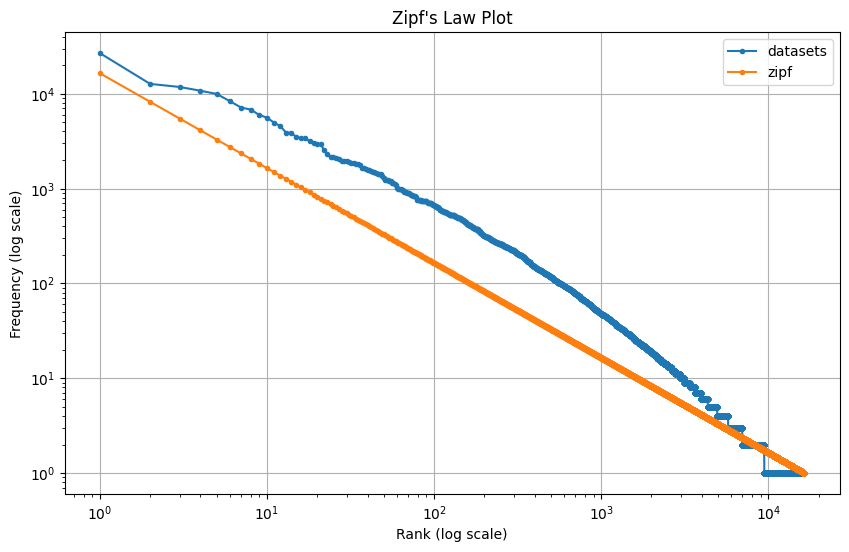

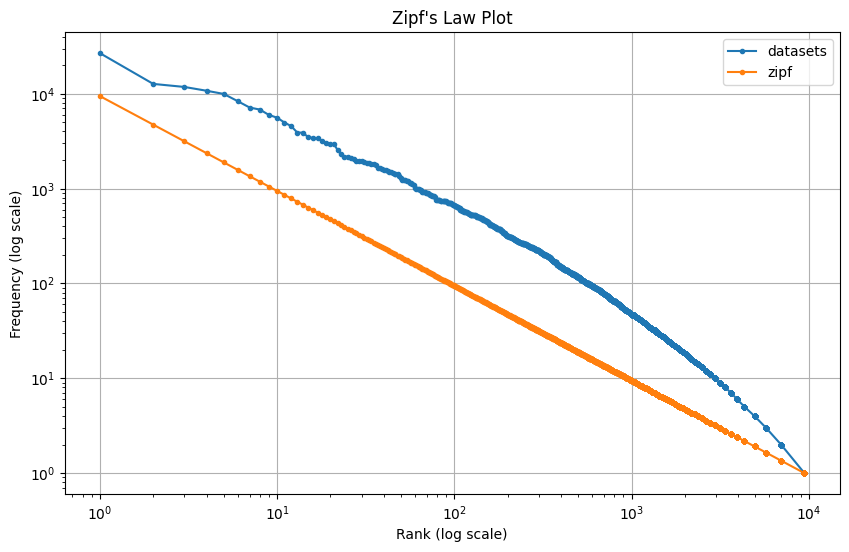

In [11]:
import matplotlib.pyplot as plt

# Create a Zipf's law plot
plt.figure(figsize=(10, 6))
plt.loglog(df_words['Rank'], df_words['Count'], marker='.', label = 'datasets')
plt.loglog(df_words['Rank'], df_words['Zipf'], marker='.', label = 'zipf')
plt.title("Zipf's Law Plot")
plt.xlabel("Rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.grid(True)
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(10, 6))
plt.loglog(df_words['Rank2'], df_words['Count'], marker='.', label = 'datasets')
plt.loglog(df_words['Rank2'], df_words['Zipf2'], marker='.', label = 'zipf')
plt.title("Zipf's Law Plot")
plt.xlabel("Rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.grid(True)
plt.legend(loc="upper right")
plt.show()


In [ ]:
#load car make and model dataset
import pandas as pd
df_brand_model = pd.read_csv('car_models_and_brands.csv',header = 0)

car_brand = list(set(df_brand_model['Brand']))
print(len(car_brand))
print(car_brand)

#clean data
car_brand.remove('car')
car_brand.remove('problem')
car_brand.remove('sedan')
car_brand.remove('seat')

car_brand.append('benz') 

car_brand = [word.strip() for word in car_brand]

car_brand = list(set(car_brand))
print(len(car_brand))
print(car_brand)

**Create dictionary {model : make}**

In [ ]:
brand_model_dict = {}

# Iterate through the DataFrame and populate the dictionary
for index, row in df_brand_model.iterrows():
    brand = row['Brand']
    model = row['Model']
    
    if brand not in brand_model_dict:
        brand_model_dict[model] = brand

print(brand_model_dict)

In [14]:
#replace model with brand

import pandas as pd
import re

df = pd.read_csv("data.csv")
df['message'] = df['message'].fillna("#")

message_list = []
for idx in df.index:
    words = "".join([char.lower() if char.lower() in """abcdefghijklmnopqrstuvwxyz'""" else '-' for char in df['message'][idx]])
    words = re.sub('-+', ' ', words)
    words = words.split()
    new_words = ""
    for word in words:
        if word in brand_model_dict.keys():
            new_words += " "+brand_model_dict[word].strip()
        else:
            new_words += " "+word.strip()

    message_list.append(new_words)

df_clean = pd.DataFrame(message_list, columns =['message'])
print(df_clean)

                                                message
0      entry level performance luxury sedan are a ho...
1      i personally think that with a few tweaks the...
2      i am debating a new purchase and these two ar...
3      great handling rwd excellent engine and the b...
4      and no manual tranny that may not matter to y...
...                                                 ...
4996   i agree with blueguydotcom the is is one fast...
4997   don't have any interest in aftermarket tuners...
4998   don't have any interest in aftermarket tuners...
4999   amg i have no use for it's mb afterall as for...
5000   bmw is like dinan just a tuner i want nothing...

[5001 rows x 1 columns]


In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# Get the list of English stop words
stop_words = set(stopwords.words('english'))

word_count_dict = {}
for idx in df_clean.index:
    words = df_clean['message'][idx].split()
    words = list(set(words))
    for word in words:
        # exclude stopwords
        if word not in stop_words:
            if word in word_count_dict.keys():
                word_count_dict[word] += 1
            else:
                word_count_dict[word] = 1

item = list(word_count_dict.items())
df_words = pd.DataFrame(item, columns =['Word', 'Count'])
df_words = df_words.sort_values(by=['Count'],ascending=False)
df_words.reset_index(inplace = True, drop = True)

top_n = 10
df_top10 = df_words[df_words.Word.isin(car_brand)].head(n=top_n)
df_top10.index = [i for i in range(top_n)]
print(df_top10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Poonnawit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


         Word  Count
0         bmw   1180
1       acura    571
2       honda    449
3    infiniti    350
4      toyota    326
5      nissan    305
6        audi    289
7      subaru    212
8  volkswagen    195
9    mercedes    180


**Lift Ratio Calculation**

In [16]:
import pandas as pd

def lift_ratio(x, y, df_clean, df_top10):

    word_counter = 0
    for idx in df_clean.index:
        words = df_clean['message'][idx].split()
        for i in range(len(words)):
            if words[i] == df_top10['Word'][x]:
                if df_top10['Word'][y] in words[i-7:i+7]:
                    word_counter += 1
                    break

    count_brand1 = df_top10['Count'][x]
    count_brand2 = df_top10['Count'][y]
    n_sample = len(df_clean.index)
    lift = (word_counter*n_sample)/(count_brand1 *count_brand2)
    return lift

**Create Matrix for MDS (multidimensional scaling) plot** 

In [ ]:
import numpy as np
mtx = [[np.nan for i in range(len(df_top10.index))] for i in range(len(df_top10.index))]
mtx = np.array(mtx)

df = pd.read_csv("data.csv")
df['message'] = df['message'].fillna("#")

for x in df_top10.index:
    for y in df_top10.index:
        if x-y > 0:
            print(df_top10['Word'][x],df_top10['Word'][y])
            lift = lift_ratio(x,y,df_clean,df_top10)
            mtx[x,y] = lift
            print(lift)
        else:
            continue

print(mtx)

In [ ]:
print(mtx)
dissim = np.divide(1, mtx, where = mtx!=0)
print(dissim) 

row, col = dissim.shape

for x in range(row):
    for y in range(col):
        if x-y > 0:    
            if dissim[x,y] == np.inf: 
                dissim[x,y] = 0
                print("replace inverse of 0 (infinity) with maximum distance",dissim.max()) 
                print("Max",np.nanmax(dissim))
                dissim[x,y] = np.nanmax(dissim)
        elif x==y:
            dissim[x,y] = 0

for x in range(row):
    for y in range(col):
        if x-y < 0:
            dissim[x,y] = dissim[y,x]

print(dissim)

df_np = pd.DataFrame(dissim)
df_np.to_excel("dissimilarity matrix.xlsx")


c:\Users\Poonnawit\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


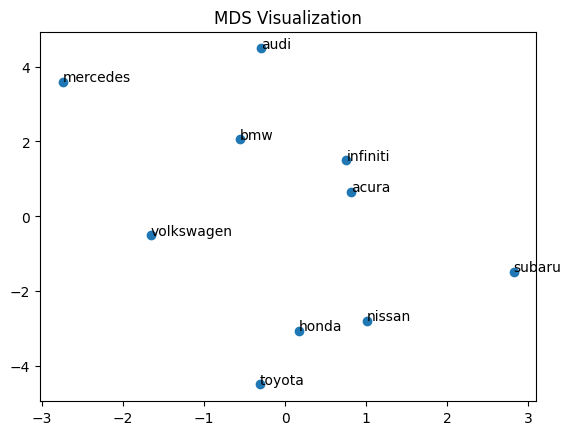

In [55]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt


#Initialize the MDS model
distance_matrix = dissim
mds = MDS(n_components=2, dissimilarity="precomputed")


#Fit the model to the distance matrix and transform the data to the lower-dimensional space
lower_dimensional_data = mds.fit_transform(distance_matrix)

#Plot the lower-dimensional representation as a scatter plot
plt.scatter(lower_dimensional_data[:, 0], lower_dimensional_data[:, 1])

#Add labels for the data points (optional)
labels = df_top10['Word']
for label, x, y in zip(labels, lower_dimensional_data[:, 0], lower_dimensional_data[:, 1]):
    plt.annotate(label, (x, y))

#Show the plot
#plt.xlabel('Dimension 1')
#plt.ylabel('Dimension 2')
plt.title('MDS Visualization')
plt.show()

**Find Lift Ratio Between Brands and Features**

In [56]:
def lift_ratio_2(x, y, df_clean, df_top_brand, df_top_feature):

    word_counter = 0
    for idx in df_clean.index:
        words = df_clean['message'][idx].split()
        for i in range(len(words)):
            if words[i] == df_top_brand['Word'][x]:
                if df_top_feature['Word'][y] in words[i-13:i+13]:
                    word_counter += 1
                    continue

    count_top_brand = df_top_brand['Count'][x]
    count_top_feature = df_top_feature['Count'][y]
    n_sample = len(df_clean.index)
    lift = (word_counter*n_sample)/(count_top_brand*count_top_feature)
    return lift

**Pick frequently mentioned car features**

In [57]:
import pandas as pd

word_count_dict = {}
 
for idx in df_clean.index:
    words = df_clean['message'][idx].split()
    words = list(set(words))
    for word in words:
        if word not in stop_words:
            if word in word_count_dict.keys():
                word_count_dict[word] += 1
            else:
                word_count_dict[word] = 1

item = list(word_count_dict.items())
df_words = pd.DataFrame(item, columns =['Word', 'Count'])
df_words = df_words.sort_values(by=['Count'],ascending=False)
df_words.reset_index(inplace = True, drop = True)
print(df_words)

top_n = 5

car_features = ["performance","hp","luxury","engine","price"]

df_top = df_words[df_words.Word.isin(car_features)].head(n=top_n)

df_top.index = [i for i in range(top_n)]
print(df_top)

          Word  Count
0          car   2555
1         like   1261
2          bmw   1180
3            g   1136
4          one   1115
...        ...    ...
16130     grid      1
16131    sewer      1
16132  butcher      1
16133  inbound      1
16134   hartge      1

[16135 rows x 2 columns]
          Word  Count
0  performance    685
1       luxury    475
2           hp    438
3       engine    436
4        price    432


In [ ]:
df_top_brand = df_top10.head(5)  
print(df_top_brand)
df_top_feature = df_top
print(df_top_feature)

import numpy as np
mtx_t = [[float(0) for i in range(len(df_top_feature.index))] for i in range(len(df_top_brand.index))]
mtx_t = np.array(mtx_t)

for x in df_top_brand.index:
    for y in df_top_feature.index:
            print(df_top_brand['Word'][x],df_top_feature['Word'][y])
            lift = lift_ratio_2(x,y,df_clean,df_top_brand,df_top_feature)
            mtx_t[x,y] = lift
            print(lift)
            
print(mtx_t)

In [59]:
print(mtx_t)
df_brand_attribute = pd.DataFrame(mtx_t, columns = df_top_feature['Word'], index = df_top_brand['Word'])
print(df_brand_attribute)

[[0.47640356 0.3836628  0.68700371 0.37909928 0.47090395]
 [0.43471947 0.79285833 0.23995394 0.38166985 0.40547772]
 [0.43901939 0.93794397 0.45772951 0.30655279 0.56721727]
 [0.20859228 0.60162406 0.45671233 0.32771953 0.42998016]
 [0.60466168 1.25953503 0.21014371 0.35184612 0.49714554]]
Word      performance    luxury        hp    engine     price
Word                                                         
bmw          0.476404  0.383663  0.687004  0.379099  0.470904
acura        0.434719  0.792858  0.239954  0.381670  0.405478
honda        0.439019  0.937944  0.457730  0.306553  0.567217
infiniti     0.208592  0.601624  0.456712  0.327720  0.429980
toyota       0.604662  1.259535  0.210144  0.351846  0.497146


**Visualize by using balloon plot** 

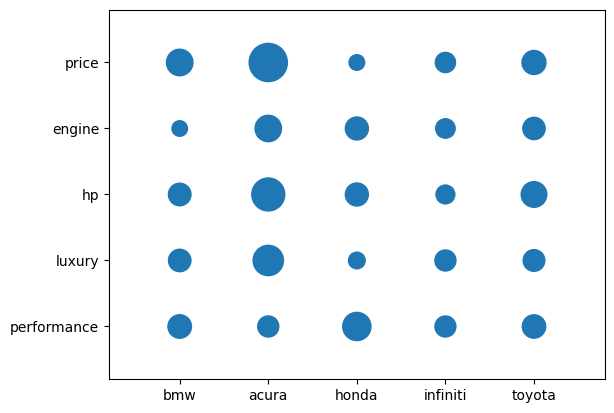

In [60]:
import numpy as np
import matplotlib.pyplot as plt

x,y = np.meshgrid(df_brand_attribute.index, df_brand_attribute.columns)

df_brand_attribute_scale = 600*df_brand_attribute

plt.scatter(x=x.flatten(), y=y.flatten(), s=df_brand_attribute_scale.values.flatten())
plt.margins(0.2)
plt.show()
